In [1]:
import pandas as pd
from utils import Options
import pickle as pkl
import numpy as np
from glob import glob
from readresults.readres_mvpa import merge_results, parse_roi_info, exclude_participants, \
    get_subj_avg, fill_in_nvoxels, quick_get_results, group_results
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
import seaborn as sns
import matplotlib.pyplot as plt
from plotting.plot import plot_by_nvoxels, get_tfce_stats
import pingouin as pg
import os
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):
/home/predatt/giaald/nipype/nipype/utils/misc.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterator
/home/predatt/giaald/nipype/nipype/interfaces/base/traits_extension.py:22: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.

In [33]:
pg.power_ttest(d=0.30, n=None, power=0.8, alpha=0.05, contrast='one-sample')

89.14936618310736

In [36]:
pg.power_ttest(d=0.30, n=30, alpha=0.05, contrast='one-sample')

0.3554627295950407

In [6]:
results = merge_results(['/project/3018040.05/MVPA_results/results_main_nothresh_1718_m29.csv',
                         '/project/3018040.05/MVPA_results/results_main_nothresh_1937_m29.csv'])
#results = exclude_participants(results)
results = parse_roi_info(results)
grouped_res = group_results(results, avg_across=['split', 'view', 'runno', 'trainmodel', 'testmodel',
                                                 'traintask', 'testtask'])
separate_res = group_results(results, avg_across=['split', 'view', 'runno'])

In [7]:
separate_res.trainmodel.unique()

array([29,  5])

In [3]:
grouped_res.head()

,subject,roi,approach,traindataformat,testdataformat,hemi,nvoxels,contrast,expected,correct,output,rawdistance,distance,runno,view,trainmodel,testmodel
0,sub-001,ba-17-18,traintest,betas,betas,L,100,objscrvsbas,False,0.534091,0.511364,0.008886,0.148671,2.636364,1.5,21.363636,12.636364
1,sub-001,ba-17-18,traintest,betas,betas,L,100,objscrvsbas,True,0.689394,0.500000,0.058115,0.451014,2.636364,1.5,21.363636,12.636364
2,sub-001,ba-17-18,traintest,betas,betas,L,200,objscrvsbas,False,0.534091,0.511364,0.001437,0.154932,2.636364,1.5,21.363636,12.636364
3,sub-001,ba-17-18,traintest,betas,betas,L,200,objscrvsbas,True,0.700758,0.481061,-0.007477,0.499321,2.636364,1.5,21.363636,12.636364
4,sub-001,ba-17-18,traintest,betas,betas,L,300,objscrvsbas,False,0.590909,0.522727,0.020737,0.236165,2.636364,1.5,21.363636,12.636364


In [5]:
results.trainmodel.unique()

array([ 5, 29])

In [4]:
overall_decoding = grouped_res[grouped_res['nvoxels']!='none'].groupby(['roi', 'subject']).mean().reset_index()

In [5]:
overall_decoding.groupby(['roi'])['distance'].agg(['mean', 'sem'])

,mean,sem
roi,,
ba-17-18,0.280363,0.019846
ba-19-37,0.174758,0.014737


In [6]:
pg.ttest(overall_decoding[overall_decoding['roi']=='ba-17-18']['distance'], 0.0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.127057,34,two-sided,8.651039e-16,"[0.24, 0.32]",2.387909,7.062e+12,1.0


In [7]:
pg.ttest(overall_decoding[overall_decoding['roi']=='ba-19-37']['distance'], 0.0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,11.85818,34,two-sided,1.249840e-13,"[0.14, 0.2]",2.004398,5.974e+10,1.0


In [8]:
pg.ttest(overall_decoding[overall_decoding['roi']=='ba-17-18']['distance'],
         overall_decoding[overall_decoding['roi']=='ba-19-37']['distance'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.112465,34,two-sided,3.219777e-08,"[0.08, 0.14]",1.021242,4.308e+05,0.999953


In [9]:
bothROIs_avg = grouped_res[grouped_res['nvoxels']!='none'].groupby(['roi', 'expected', 'subject']).mean().reset_index()

In [10]:
aov = pg.rm_anova(data=bothROIs_avg, dv='distance', within=['roi', 'expected'],
            subject='subject')
aov.round(4)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,roi,0.3903,1,34,0.3903,50.5872,0.0000,0.0000,0.5980,1.0
1,expected,0.0270,1,34,0.0270,2.1916,0.1480,0.1480,0.0606,1.0
2,roi * expected,0.0390,1,34,0.0390,12.1808,0.0014,0.0014,0.2638,1.0


In [ ]:
bothROIs_m5 = separate_res[(separate_res['testmodel']==5)&(separate_res['nvoxels']!='none')].groupby(['roi', 'expected', 'subject']).mean().reset_index()
aov = pg.rm_anova(data=bothROIs_m5, dv='distance', within=['roi', 'expected'],
            subject='subject')
aov.round(4)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,roi,0.5622,1,34,0.5622,73.2914,0.0000,0.0000,0.6831,1.0
1,expected,0.0191,1,34,0.0191,1.4053,0.2441,0.2441,0.0397,1.0
2,roi * expected,0.0406,1,34,0.0406,11.3042,0.0019,0.0019,0.2495,1.0


In [10]:
bothROIs_m29 = separate_res[(separate_res['testmodel']==29)&(separate_res['nvoxels']!='none')].groupby(['roi', 'expected', 'subject']).mean().reset_index()
aov = pg.rm_anova(data=bothROIs_m29, dv='distance', within=['roi', 'expected'],
            subject='subject')
aov.round(4)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,roi,0.1274,1,34,0.1274,9.9491,0.0034,0.0034,0.2264,1.0
1,expected,0.0482,1,34,0.0482,3.4248,0.0729,0.0729,0.0915,1.0
2,roi * expected,0.0357,1,34,0.0357,9.3328,0.0044,0.0044,0.2154,1.0


In [21]:
results_1718 = grouped_res[(grouped_res['roi']=='ba-17-18')&(grouped_res['nvoxels']!='none')]
results_1937 = grouped_res[(grouped_res['roi']=='ba-19-37')&(grouped_res['nvoxels']!='none')]

# separate by decoding direction:
results_1718_m29 = separate_res[(separate_res['testmodel']==29)&(separate_res['roi']=='ba-17-18')&(separate_res['nvoxels']!='none')]
results_1937_m29 = separate_res[(separate_res['testmodel']==29)&(separate_res['roi']=='ba-19-37')&(separate_res['nvoxels']!='none')]
results_1718_m5 = separate_res[(separate_res['testmodel']==5)&(separate_res['roi']=='ba-17-18')&(separate_res['nvoxels']!='none')]
results_1937_m5 = separate_res[(separate_res['testmodel']==5)&(separate_res['roi']=='ba-19-37')&(separate_res['nvoxels']!='none')]

In [13]:
voxelavg_1718 = results_1718.groupby(['subject', 'expected']).mean().reset_index()
voxelavg_1718.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.249800,0.023894
True,0.310926,0.023362


In [14]:
voxelavg_1937 = results_1937.groupby(['subject', 'expected']).mean().reset_index()
voxelavg_1937.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.177572,0.016505
True,0.171944,0.016607


In [14]:
pg.ttest(voxelavg_1718[voxelavg_1718['expected']==True].distance,
         voxelavg_1718[voxelavg_1718['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.382969,34,two-sided,0.022906,"[0.01, 0.11]",0.437261,2.13,0.709968


In [22]:
voxelavg_1718_m29 = results_1718_m29.groupby(['subject', 'expected']).mean().reset_index()
voxelavg_1718_m29.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.279235,0.024448
True,0.348271,0.023783


In [23]:
voxelavg_1718_m5 = results_1718_m5.groupby(['subject', 'expected']).mean().reset_index()
voxelavg_1718_m5.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.236063,0.025755
True,0.293498,0.024259


In [24]:
pg.ttest(voxelavg_1718_m29[voxelavg_1718_m29['expected']==True].distance,
         voxelavg_1718_m29[voxelavg_1718_m29['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.749263,34,two-sided,0.009495,"[0.02, 0.12]",0.483849,4.466,0.794133


In [25]:
pg.ttest(voxelavg_1718_m5[voxelavg_1718_m5['expected']==True].distance,
         voxelavg_1718_m5[voxelavg_1718_m5['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.08262,34,two-sided,0.04488,"[0.0, 0.11]",0.388047,1.229,0.606659


In [26]:
pg.ttest(voxelavg_1937[voxelavg_1937['expected']==True].distance,
         voxelavg_1937[voxelavg_1937['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.372982,34,two-sided,0.711477,"[-0.04, 0.03]",0.057454,0.194,0.062598


In [16]:
pg.ttest(voxelavg_1718[voxelavg_1718['expected']==True].correct,
         voxelavg_1718[voxelavg_1718['expected']==False].correct,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.386427,34,two-sided,0.022723,"[0.0, 0.05]",0.439689,2.144,0.714722


In [17]:
pg.ttest(voxelavg_1937[voxelavg_1937['expected']==True].correct,
         voxelavg_1937[voxelavg_1937['expected']==False].correct,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.128587,34,two-sided,0.898442,"[-0.02, 0.01]",0.021097,0.183,0.051688


In [16]:
avg1718_left = results_1718[results_1718['hemi']=='L'].groupby(['subject', 'expected']).mean().reset_index()
avg1718_right = results_1718[results_1718['hemi']=='R'].groupby(['subject', 'expected']).mean().reset_index()

In [17]:
avg1718_left.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.290835,0.028608
True,0.335884,0.026421


In [18]:
pg.ttest(avg1718_left[avg1718_left['expected']==True].distance,
         avg1718_left[avg1718_left['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.454187,34,two-sided,0.155064,"[-0.02, 0.11]",0.276533,0.474,0.355835


In [19]:
avg1718_right.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.208764,0.023808
True,0.285968,0.023949


In [20]:
pg.ttest(avg1718_right[avg1718_right['expected']==True].distance,
         avg1718_right[avg1718_right['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.696251,34,two-sided,0.010827,"[0.02, 0.14]",0.546514,3.995,0.881136


In [21]:
# _, _, tfce_pvals_1718, _ = get_tfce_stats(results_1718.groupby(['subject', 'nvoxels', 'expected']).mean().reset_index(),
#                                           measure='distance', n_perms=10000)

In [22]:
tfce_pvals_1718 = [0.1978, 0.0262, 0.0231, 0.0248, 0.022 , 0.019 , 0.0234, 0.0225,
       0.0227, 0.0236, 0.0258, 0.0274, 0.0262, 0.0301, 0.0382, 0.0419,
       0.048 , 0.0541, 0.0622, 0.0622, 0.0673, 0.0673, 0.0774, 0.0883,
       0.0933, 0.0945, 0.104 , 0.106 , 0.1022, 0.104 , 0.104 , 0.104 ,
       0.106 , 0.1113, 0.113 , 0.1113, 0.1148, 0.113 , 0.113 , 0.1148,
       0.1169, 0.1196, 0.1236, 0.1264, 0.1236, 0.1264, 0.1264, 0.129 ,
       0.129 , 0.1318, 0.1318, 0.1318, 0.1318, 0.1349, 0.1349, 0.1349,
       0.1349, 0.1349, 0.1349, 0.1349]

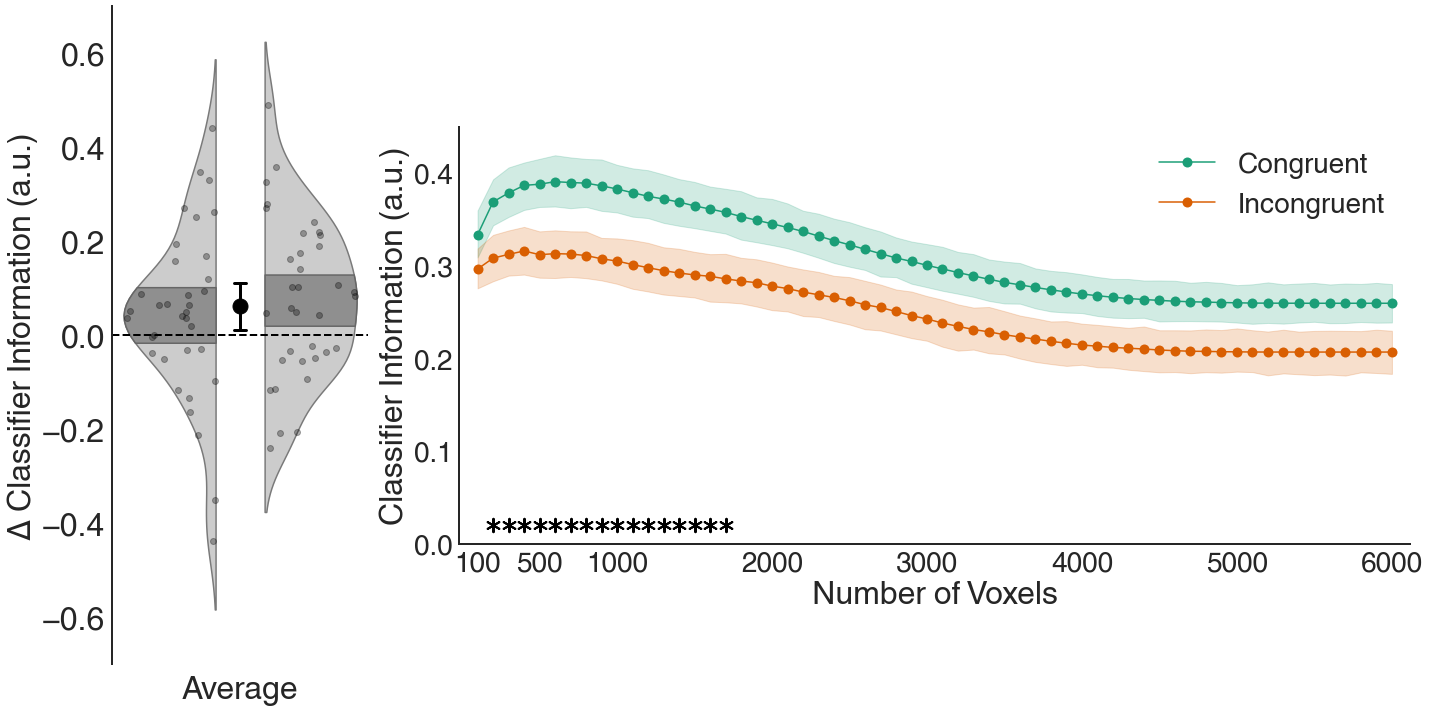

In [23]:
plot_by_nvoxels(results_1718, right_part=True, tfce_pvals=tfce_pvals_1718)
plt.savefig('results_plots/ba1718_nvox.svg') #dpi=300, facecolor='white', transparent=False)

stat_fun(H1): min=2.121917 max=3.107932
Running initial clustering
Using 311 thresholds from 0.00 to 3.10 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


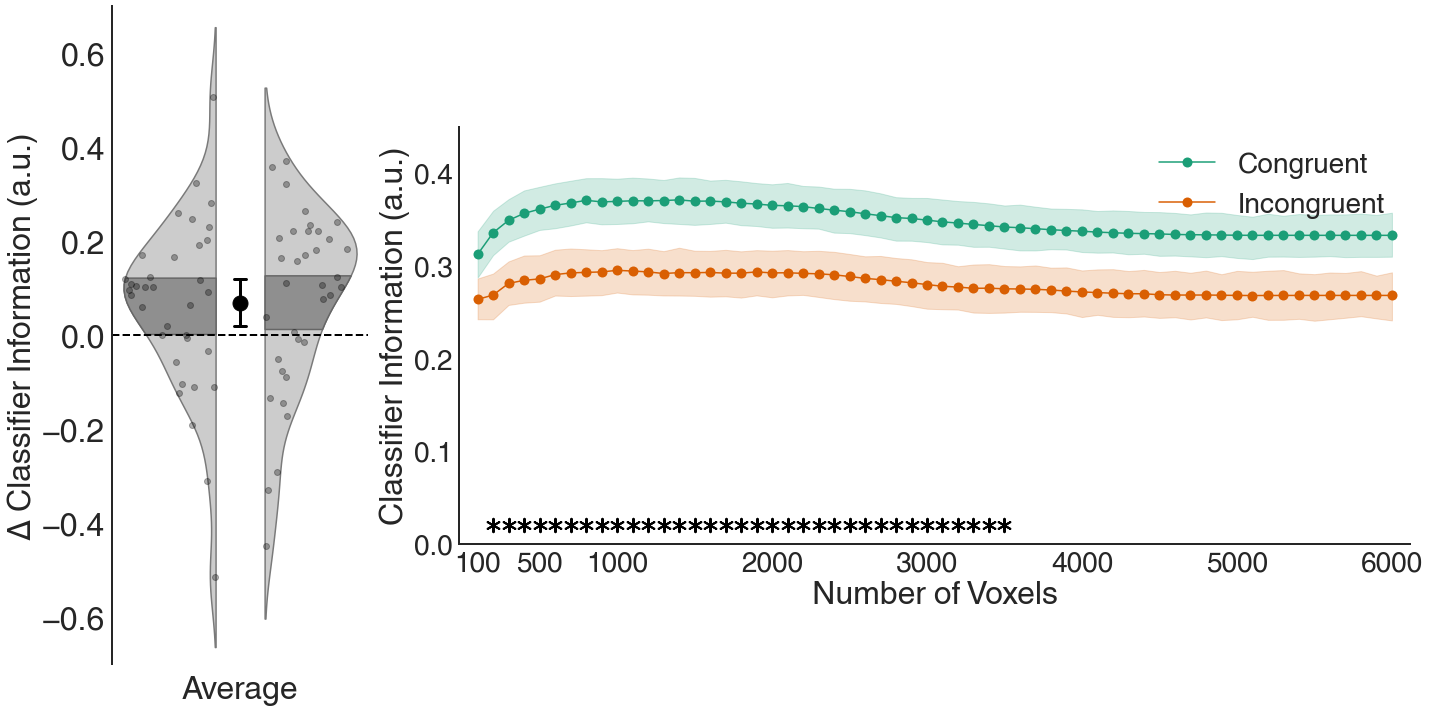

In [27]:
plot_by_nvoxels(results_1718_m29, right_part=True)
plt.savefig('results_plots/ba1718_nvox_m29.svg')

stat_fun(H1): min=1.386627 max=2.764496
Running initial clustering
Using 277 thresholds from 0.00 to 2.76 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


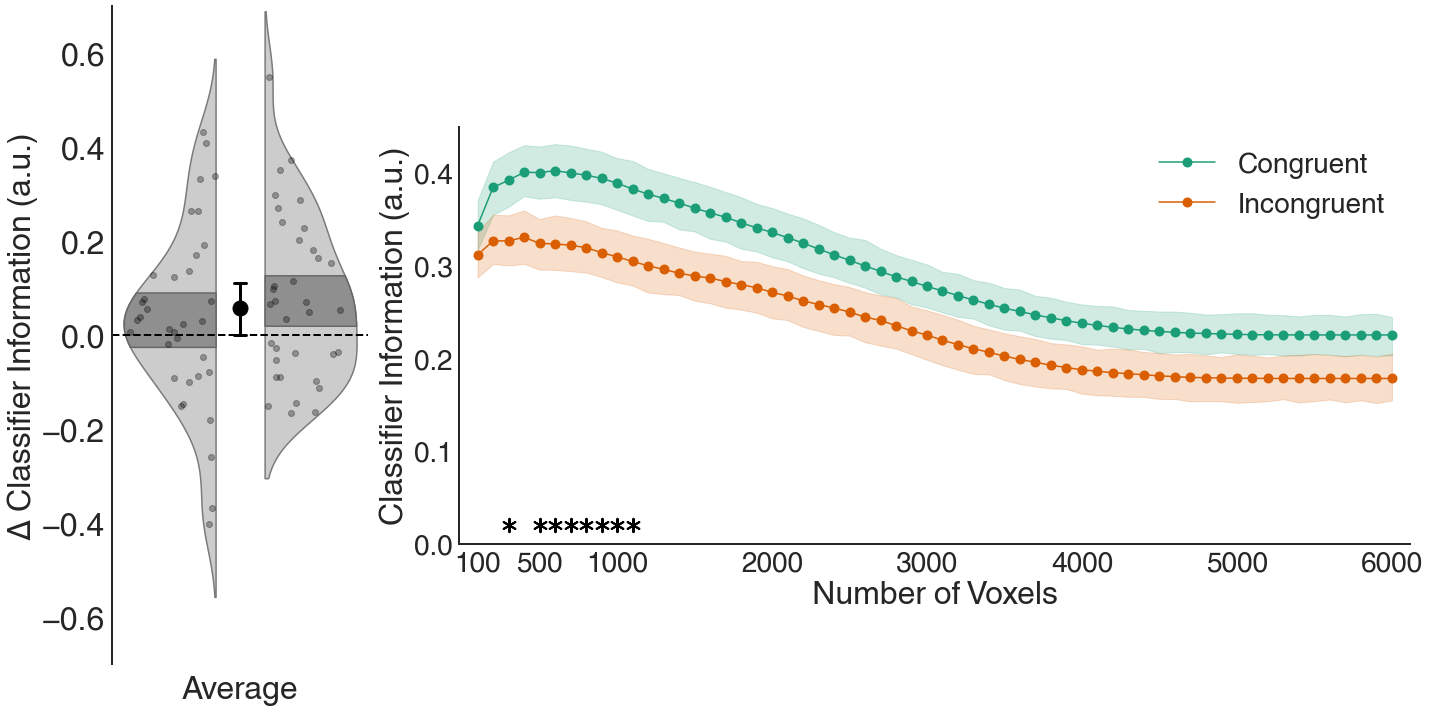

In [28]:
plot_by_nvoxels(results_1718_m5, right_part=True)
plt.savefig('results_plots/ba1718_nvox_m5.svg')

stat_fun(H1): min=-0.426019 max=1.369227
Running initial clustering
Using 137 thresholds from 0.00 to 1.36 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


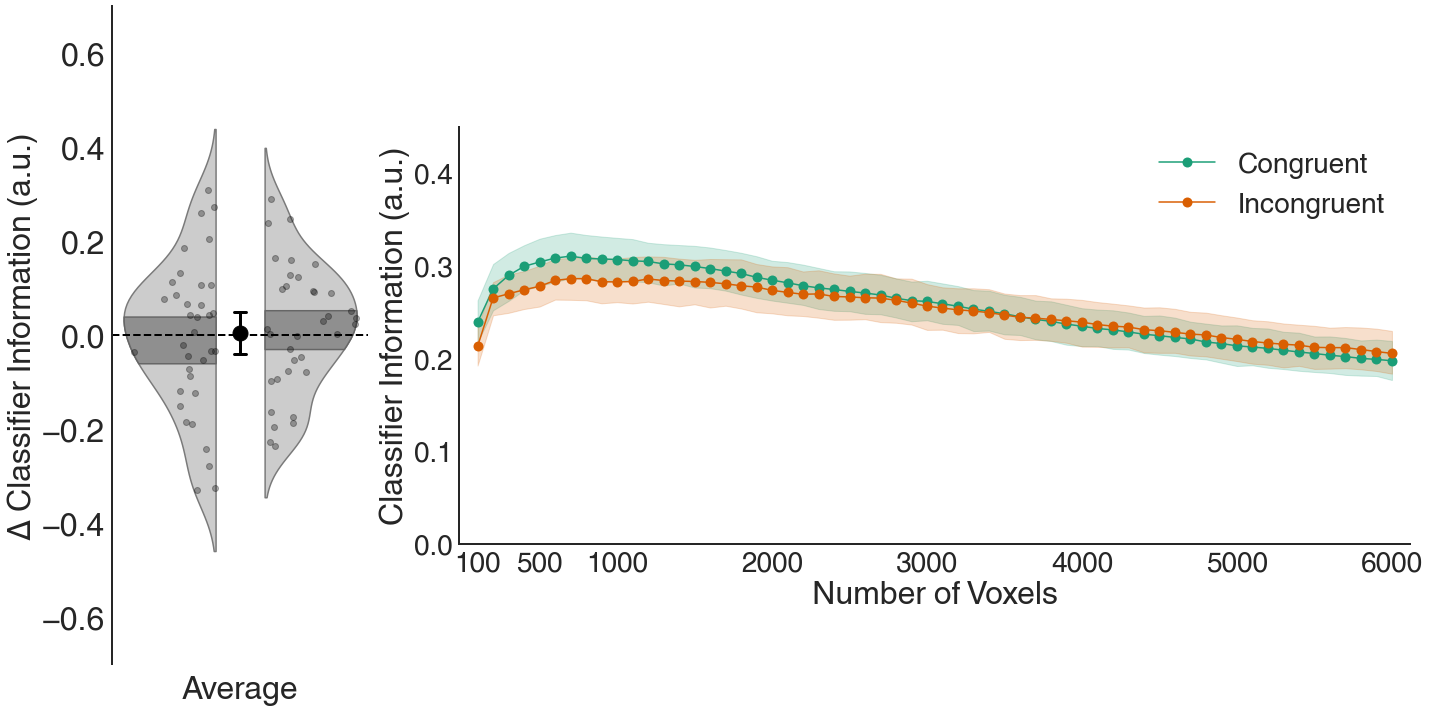

In [29]:
plot_by_nvoxels(results_1937_m29, right_part=True)
plt.savefig('results_plots/ba1937_nvox_m29.svg')

stat_fun(H1): min=-1.113629 max=1.580378
Running initial clustering
Using 159 thresholds from 0.00 to 1.58 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


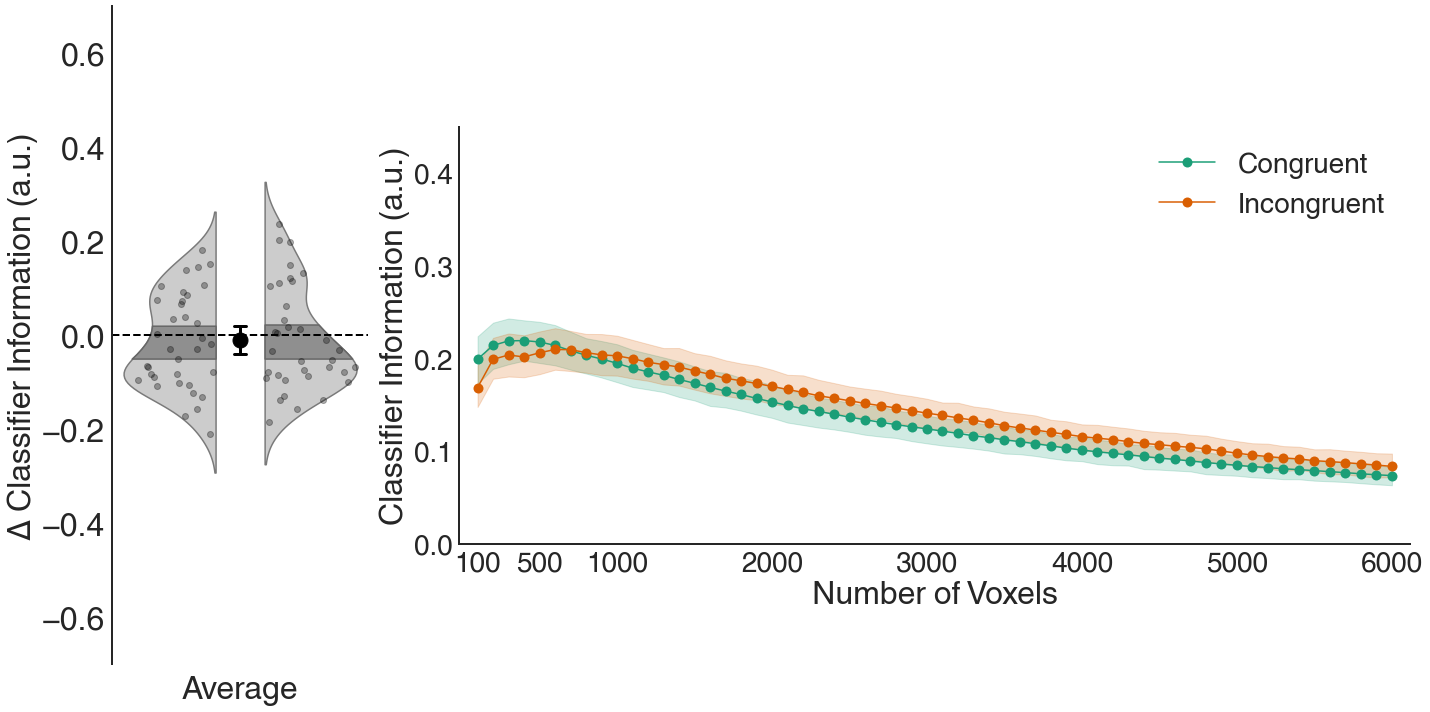

In [30]:
plot_by_nvoxels(results_1937_m5, right_part=True)
plt.savefig('results_plots/ba1937_nvox_m5.svg')

In [24]:
# _, _, tfce_pvals_1937, _ = get_tfce_stats(results_1937.groupby(['subject','nvoxels','expected']).mean().reset_index(),
#                                              measure='distance', n_perms=10000)

In [25]:
tfce_pvals_1937 = [0.369 , 0.9122, 0.789 , 0.6259, 0.7545, 0.9349, 0.992 , 0.9984,
       0.9985, 1.    , 1.    , 1.    , 1.    , 0.9999, 0.9999, 0.9992,
       0.9988, 0.9979, 0.9897, 0.9868, 0.9825, 0.9724, 0.9669, 0.9669,
       0.953 , 0.9461, 0.9275, 0.9122, 0.9315, 0.953 , 0.949 , 0.9461,
       0.9349, 0.9424, 0.953 , 0.953 , 0.9424, 0.9389, 0.9228, 0.9228,
       0.9173, 0.9173, 0.9122, 0.9228, 0.9069, 0.9069, 0.9013, 0.8733,
       0.9069, 0.9173, 0.9389, 0.949 , 0.949 , 0.9461, 0.9582, 0.949 ,
       0.9389, 0.9424, 0.953 , 0.961 ]

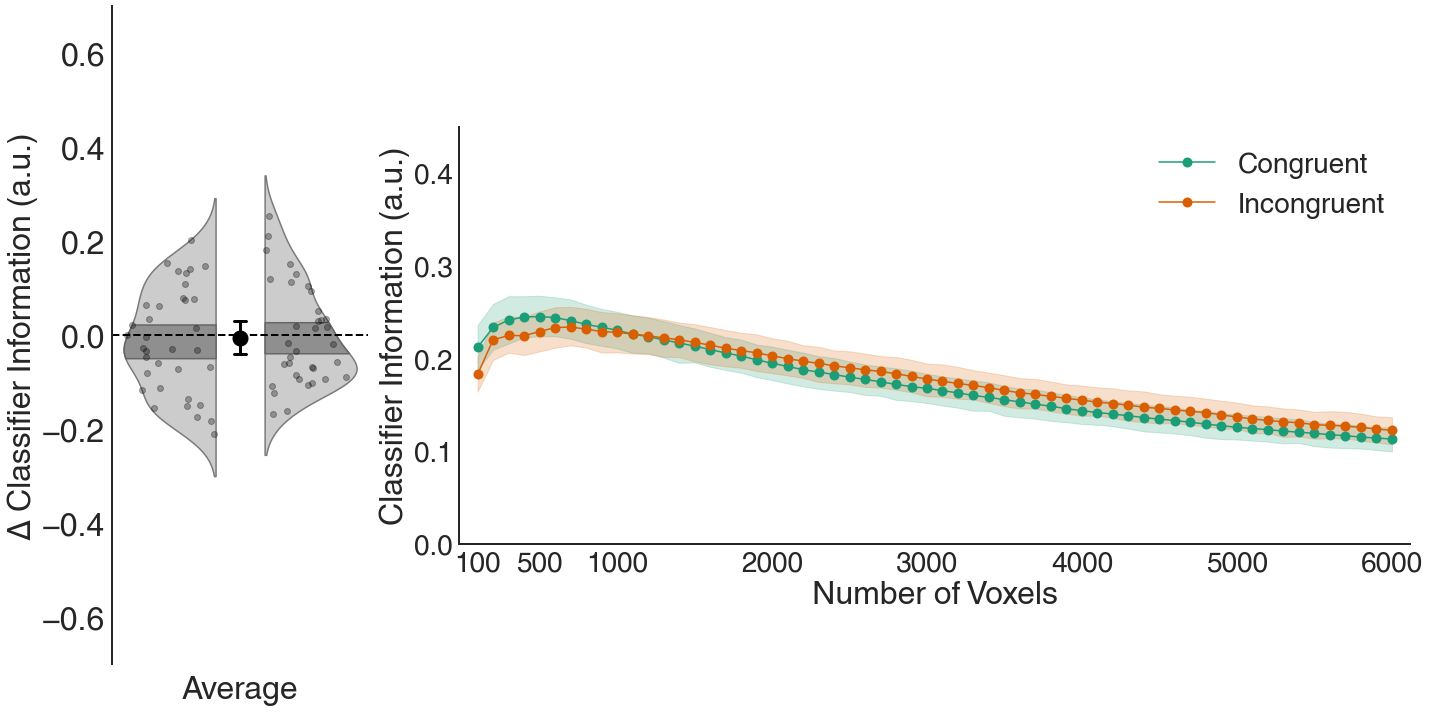

In [26]:
plot_by_nvoxels(results_1937, right_part=True, tfce_pvals=tfce_pvals_1937)
plt.savefig('results_plots/ba1937_nvox.svg')

In [27]:
voxelavg_1937 = results_1937.groupby(['subject', 'expected']).mean().reset_index()
voxelavg_1937.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.177572,0.016505
True,0.171944,0.016607


In [28]:
pg.ttest(voxelavg_1937[voxelavg_1937['expected']==True].distance,
         voxelavg_1937[voxelavg_1937['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.372982,34,two-sided,0.711477,"[-0.04, 0.03]",0.057454,0.194,0.062598


In [29]:
avg1937_left = results_1937[results_1937['hemi']=='L'].groupby(['subject', 'expected']).mean().reset_index()
avg1937_right = results_1937[results_1937['hemi']=='R'].groupby(['subject', 'expected']).mean().reset_index()

In [30]:
avg1937_left.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.160628,0.019119
True,0.149607,0.016552


In [31]:
pg.ttest(avg1937_left[avg1937_left['expected']==True].distance,
         avg1937_left[avg1937_left['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.582887,34,two-sided,0.563816,"[-0.05, 0.03]",0.104178,0.212,0.092023


In [32]:
avg1937_right.groupby(['expected']).distance.agg(['mean', 'sem'])

,mean,sem
expected,,
False,0.194516,0.020776
True,0.194282,0.019391


In [33]:
pg.ttest(avg1937_right[avg1937_right['expected']==True].distance,
         avg1937_right[avg1937_right['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.012853,34,two-sided,0.98982,"[-0.04, 0.04]",0.001968,0.181,0.050015


## Plots with accuracy (instead of classifier information)

In [34]:
pg.ttest(voxelavg_1718[voxelavg_1718['expected']==True].correct,
         voxelavg_1718[voxelavg_1718['expected']==False].correct,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.386427,34,two-sided,0.022723,"[0.0, 0.05]",0.439689,2.144,0.714722


In [35]:
pg.ttest(voxelavg_1937[voxelavg_1937['expected']==True].distance,
         voxelavg_1937[voxelavg_1937['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.372982,34,two-sided,0.711477,"[-0.04, 0.03]",0.057454,0.194,0.062598


In [ ]:
# avg1718_nvoxels = results_1718.groupby(['subject', 'nvoxels', 'expected']).mean().reset_index()
# _, _, tfce_pvals_1718, _ = get_tfce_stats(avg1718_nvoxels.groupby(['subject','nvoxels','expected']).mean().reset_index(),
#                                              measure='correct', n_perms=10000)

stat_fun(H1): min=0.982830 max=2.837659
Running initial clustering
Using 284 thresholds from 0.00 to 2.83 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [38]:
tfce_pvals_1718 = [0.7673, 0.0351, 0.1031, 0.0798, 0.0742, 0.0727, 0.0975, 0.0709,
       0.1048, 0.1413, 0.0727, 0.0633, 0.0579, 0.0406, 0.0774, 0.0503,
       0.0394, 0.0452, 0.0689, 0.0592, 0.0478, 0.0709, 0.1224, 0.1531,
       0.1697, 0.1725, 0.2065, 0.1856, 0.1934, 0.1667, 0.1891, 0.1224,
       0.1311, 0.1514, 0.1488, 0.1413, 0.1163, 0.1514, 0.1531, 0.1667,
       0.1725, 0.1413, 0.1458, 0.1596, 0.1427, 0.1633, 0.1427, 0.1697,
       0.1633, 0.138 , 0.1514, 0.1488, 0.1458, 0.1458, 0.1488, 0.1488,
       0.1488, 0.1488, 0.1488, 0.1488]

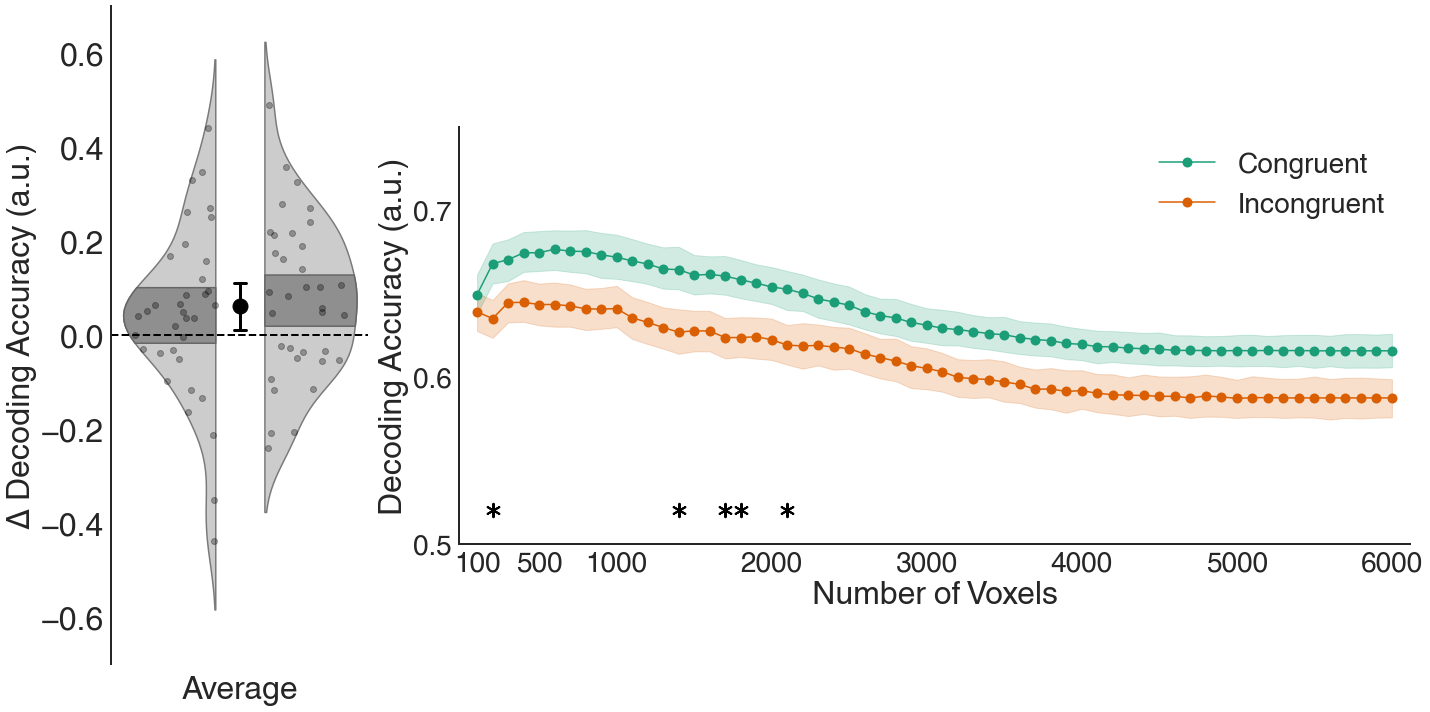

In [39]:
plot_by_nvoxels(results_1718, measure='correct', 
                tfce_pvals=tfce_pvals_1718,
                right_part=True)
plt.savefig('results_plots/ba1718_nvox_accuracy.svg')

In [42]:
# avg1937_nvoxels = results_1937.groupby(['subject', 'nvoxels', 'expected']).mean().reset_index()
# _, _, tfce_pvals_1937, _ = get_tfce_stats(avg1937_nvoxels.groupby(['subject','nvoxels','expected']).mean().reset_index(),
#                                              measure='correct', n_perms=10000)

In [43]:
tfce_pvals_1937 = [0.8014, 1.    , 0.7218, 0.6682, 0.909 , 0.6319, 0.7646, 0.9991,
       0.9972, 0.9994, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 0.9999, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 0.998 , 1.    , 0.982 , 0.9926,
       0.9808, 0.9915, 0.9839, 0.9839, 0.8308, 0.9499, 0.7953, 0.8014,
       0.9717, 0.8904, 0.9808, 0.9989, 0.9991, 0.9966, 0.9999, 0.9966,
       0.9996, 1.    , 0.9998, 1.    ]

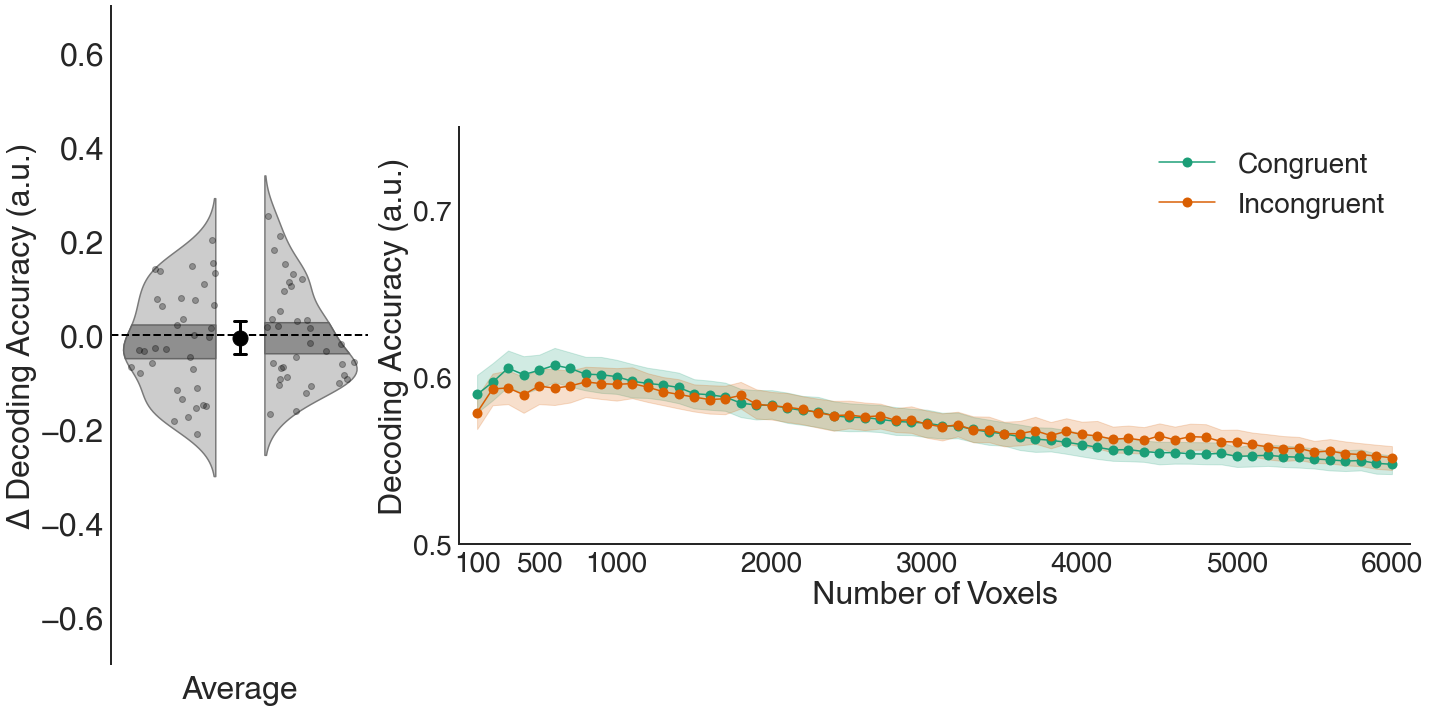

In [44]:
plot_by_nvoxels(results_1937, measure='correct', 
                tfce_pvals=tfce_pvals_1937,
                right_part=True)
plt.savefig('results_plots/ba1937_nvox_accuracy.svg')

#
#
#

In [ ]:
plot_by_nvoxels(results_1937, right_part=True)
plt.savefig('results_plots/ba1937_nvox.pdf')

In [ ]:
plot_by_nvoxels(results_1718)

In [ ]:
fullroi_1718 = grouped_res[(grouped_res['roi']=='ba-17-18')&(grouped_res['nvoxels']==6100)]
pg.ttest(fullroi_1718[fullroi_1718['expected']==True].distance,
         fullroi_1718[fullroi_1718['expected']==False].distance,
         paired=True)

In [ ]:
fullroi_1937 = grouped_res[(grouped_res['roi']=='ba-19-37')&(grouped_res['nvoxels']==6100)]
pg.ttest(fullroi_1937[fullroi_1937['expected']==True].distance,
         fullroi_1937[fullroi_1937['expected']==False].distance,
         paired=True)

In [ ]:
sns.lineplot(data=grouped_res[grouped_res['roi']=='ba-19-37'], 
             x='nvoxels', y='distance', hue='expected', ci=68)

In [ ]:
plot_by_nvoxels(results)

In [ ]:
meanres = results.groupby(['subject', 'expected']).mean().reset_index()

In [ ]:
pg.ttest(meanres[meanres['expected']==True]['distance'],
         meanres[meanres['expected']==False]['distance'], paired=True)

In [ ]:
t_obs, clusters, cluster_pv, H0 = get_tfce_stats(results, measure='distance', n_perms=1000)

In [ ]:
cluster_pv

In [ ]:
t_obs

In [ ]:
EVCdata.distance.min()

In [ ]:
LOCdata.distance.max()

In [ ]:
len(EVCdata)/34/30

In [ ]:
EVCdata.roi.nunique()

In [ ]:
plot_by_nvoxels(results)

In [ ]:
plot_by_nvoxels(EVCdata)

In [ ]:
'ba-17-18' in EVCdata.roi.unique()

In [ ]:
EVCdata.roi

In [ ]:
from plotting.plot import accs_to_diffs

avgdiffs = accs_to_diffs(EVCdata)

In [ ]:
avgdiffs = avgdiffs.groupby(['subject', 'hemi']).mean().reset_index()

In [ ]:
avgdiffs.difference.max()

In [ ]:
avgdiffs.difference.min()

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
maxvoxels = 3000
['100']+[str(x) for x in np.arange(500, maxvoxels+500, 500)]

In [ ]:
EVCdata[EVCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
LOCdata[LOCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
avgres

In [ ]:
results[results['approach']=='CV'].chunk.unique()

In [ ]:
from readresults.readres_mvpa import parse_roi_info

In [ ]:
results_avg = results.groupby(['subject', 'roi']).mean().reset_index()

In [ ]:
results = parse_roi_info(results)

In [ ]:
results = results.drop(['chunk'], axis=1)

In [ ]:
ind_vars = ['subject', 'roi', 'approach', 
            'traindataformat', 'testdataformat', 'traintask',
            'testtask', 'trainmodel', 'testmodel', 
            'hemi', 'contrast', 'nvoxels']
ind_vars = [i for i in ind_vars if i in results.columns and results[i].nunique() > 0]

In [ ]:
results_avg = results.groupby(ind_vars).mean().reset_index()

In [ ]:
results_avg = results_avg.drop(['chunk'], axis=1)

In [ ]:
results_avg.head()

In [ ]:
sns.barplot(data=results_avg, x='roi', y='distance')

In [ ]:
allinfo = 'LO_contr-objscrvsbas_top-1000'.split('_')

In [ ]:
allinfo[1] in ['L', 'R']

In [ ]:
allinfo

In [ ]:
contrindx = 1

In [ ]:
allinfo[contrindx].split('contr-')[1]

In [ ]:
a = [None, None, None]
all(v is None for v in a)

In [ ]:
sns.barplot(data=results, x='roi', y='correct')

In [ ]:
results[results['roi'].isin(['rBA17_18_L', 'rBA17_18_R',
                             'ba-17-18_L', 'ba-17-18_R'])].distance.mean()

In [ ]:
outputs = [0.3, 4.0, 6.9, 2.0, 3.5, 0.1]
targets = [4.7, 3.2, 1.0, 2.9, 3.2, 6.8]
splits = [1, 1, 1, 2, 2, 2]
example_res = pd.DataFrame(
    list(zip(outputs, targets, splits)),
    columns=['output', 'target', 'split'])

In [ ]:
example_res

In [ ]:
x = np.array([3, 4, 5])
np.isin(x, [5])

In [ ]:
example_res = np.nan
isinstance(example_res, float) and pd.isnull(example_res)

In [ ]:
pd.isna(example_res).all()

In [ ]:
outs2 = [0.5, 0.65, 1.2]
splits2 = [3, 3, 3]
example_res_2 = pd.DataFrame(
    list(zip(outs2, splits2)),
    columns=['output', 'split'])

In [ ]:
all_res = pd.concat([example_res, example_res_2])

In [ ]:
all_res

In [ ]:
for s in sorted(example_res.split.unique()):
    thissplitlength = len(example_res[example_res['split']==s])
    example_res.loc[example_res['split']==s, 'sample'] = list(range(thissplitlength))

In [ ]:
groupedres = example_res.groupby('sample').mean().reset_index().drop(['sample', 'split'], axis=1)

In [ ]:
groupedres

In [ ]:
agg_functions = {'output': 'mean', 'target': 'sum'}

#create new DataFrame by combining rows with same id values
res_new = example_res.groupby(example_res['split']).aggregate(
    agg_functions)

In [ ]:
res_new

In [ ]:
with open('/project/3018040.05/MVPA_results/traintest.pkl', 'rb') as f:
    results = pkl.load(f)

In [ ]:
res = results['train-trainm3-test-testm3_ba-17-18_L_betas'][0]
accuracy = res[:, 0]==res[:, 1]
res_df = pd.DataFrame(res, 
                      columns = ['output', 'target', 'distance', 'chunk'])

In [ ]:
res_df['trialno'] = 1

In [ ]:
res_df.to_numpy()

In [ ]:
accuracy.shape

In [ ]:
random = np.random.rand(accuracy.shape[0])

In [ ]:
random

In [ ]:
output = (res[:, 0] == np.unique(res[:, 1])[0]).astype(int)

In [ ]:
output

In [ ]:
np.mean([True, True, False])

In [ ]:
outputs = 

In [ ]:
res_df.distance.dtype

In [ ]:
results['train-trainm3-test-testm3_ba-17-18_L_betas'][0].shape

In [ ]:
opt = Options()

In [ ]:
import configs

In [ ]:
dir(configs)

In [ ]:
configs.mvpa_outdir

In [ ]:
from configs import mvpa_outdir as data_dir

In [ ]:
from six.moves import cPickle as pickle

In [ ]:
data_dir

In [ ]:
mvpa_datadir

In [ ]:
x

In [ ]:
opt.sub = 'sub-001'

In [ ]:
opt.sub

In [ ]:
eventsfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_run-1_events.tsv'
behavfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_beh.tsv'
events = pd.read_csv(eventsfile, sep='\t')
behav = pd.read_csv(behavfile, sep='\t')

In [ ]:
events

In [ ]:
bedscenes = [2, 5, 6, 7, 9, 13, 14, 17, 18, 20]
bedindx = behav.index[behav['Scene'].isin(bedscenes)]
couchindx = behav.index[~behav['Scene'].isin(bedscenes)]

In [ ]:
bedindx

In [ ]:
couchindx